Performance de estudantes

# Importação do que é necessário para execução do código em Python.

In [24]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier


# Carga do *Dataset*

    O *dataset* possue dados de vários estudantes com idades entre 15 e 18 anos, onde cada registro representa um único estudante. Os dados são referentes a dados demográficos, hábitos de estudo, envolvimento dos pais e atividades extracurriculares. A última coluna, "GradeClass", indica qual o resultado da classificação da média final do estudante.

# Sobre o arquivo:

## ID do estudante

    StudentID: ID do estudante.


## Dados demográficos

    Age: Idade do estudante entre 15 e 18.
    Gender: Gênero do estudante onde 0 é masculino e 1 é feminino.
    Ethnicity: Etnia do estudante, codificado entre:
        0: Caucasiano
        1: Afrodescendente
        2: Asiático
        3: Outros
    ParentalEducation: Nível de educação dos pais, codificados entre:       
        0: Nenhuma
        1: Ensino médio
        2: Ensino fundamental
        3: Ensino Superior
        4: Acima de superior


## Hábitos de estudo

    StudyTimeWeekly: Frequência de estudos semanais em horas. Entre 0 e 20.
    Absences: Número de faltas durante o ano letivo. De 0 a 30.
    Tutoring: Indica se o estudante faz ou não aulas particulares.


## Envolvimento dos pais

    ParentalSupport: Nível de suporte dos pais, indicando:        
        0: Nenhum
        1: Baixo
        2: Moderado
        3: Alto
        4: Muito alto


## Atividades extracurriculares

    Extracurricular: Indica se estudante pratica atividades extracurriculares.
    Sports: Indica se estudante pratica atividades esportivas.
    Music: Indica se estudante pratica atividades musicais.
    Volunteering: Indica se estudante pratica voluntariado.

## Performance acadêmica

    GPA (Grade Point Average): Uma escala de 2.0 a 4.0, influenciada por hábitos de estudo, envolvimento dos pais na educação e atividades extracurriculares.

## Variávei *target*: Grade Class

    GradeClass: Classificação da média baseado no GPA:
        0: 'A' (GPA >= 3.5)
        1: 'B' (3.0 <= GPA < 3.5)
        2: 'C' (2.5 <= GPA < 3.0)
        3: 'D' (2.0 <= GPA < 2.5)
        4: 'F' (GPA < 2.0)

## Objetivo

    O objetivo é prever a classificação da média do estudante, com base em dados demográficos, hábitos de estudo, envolvimento dos pais e atividades extracurriculares.


In [25]:
# Informa a URL de importação do dataset
base_url = 'https://raw.githubusercontent.com'
author = 'jonathangsilveira'
repo = 'mvp-predicao-media-alunos-api'
dataset_filepath = 'main/machine_learning/data/performance-alunos-dataset.csv'
url = f'{base_url}/{author}/{repo}/{dataset_filepath}'

# Lê o arquivo
dataset = pd.read_csv(url, skiprows=0, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Remover colunas desnecessárias do *Dataframe*

In [26]:
dataset.drop(['StudentID', 'GPA'], axis=1, inplace=True)

dataset.shape

(2392, 13)



*   A coluna alvo é `GradeClass`, isso porquê a coluna `GPA` deveria ser removida uma vez que fornece informação semelhante ao nosso alvo.
*   Depois de remover as colunas `StudentID` e `GPA`, o *dataset* consiste em 13 colunas.



# Separação em conjunto de treino e conjunto de teste com *holdout*

In [27]:
test_size = 0.30 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
x = array[:,0:12]
y = array[:,-1]
# holdout com estratificação
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=test_size, shuffle=True,
    random_state=seed, stratify=y
)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10

# validação cruzada com estratificação
kfold = StratifiedKFold(
    n_splits=num_particoes,
    shuffle=True,
    random_state=seed
)

# Modelagem e Inferência

# Criação e avaliação de modelos: linha base

LR: 0.720370 (0.026231)
CART: 0.608679 (0.028241)
KNN: 0.673200 (0.031900)
SVM: 0.710258 (0.026911)
NB: 0.657667 (0.022401)
Bagging: 0.704266 (0.037454)
RF: 0.695933 (0.027724)
ET: 0.666652 (0.021852)
AB: 0.635019 (0.035174)
GB: 0.710237 (0.033527)
Voting: 0.719172 (0.027598)


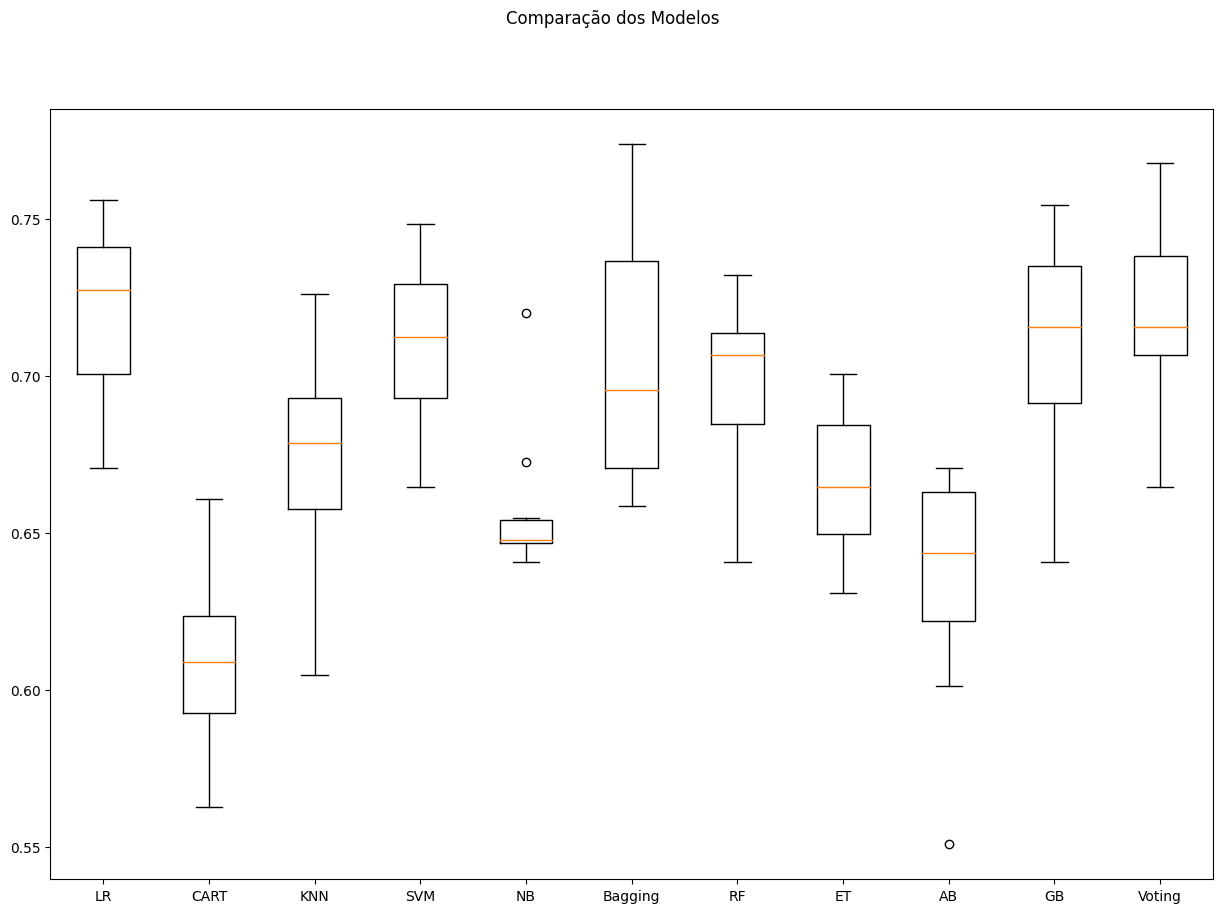

In [28]:
# definindo uma semente global
np.random.seed(seed)

# número máximo de iterações para o algoritmo de regressão logística
lr_max_iter = 200

# Criando os modelos e adicionando-os na lista de modelos
training_models = []
training_models.append(('LR', LogisticRegression(max_iter=lr_max_iter)))
training_models.append(('CART', DecisionTreeClassifier()))
training_models.append(('KNN', KNeighborsClassifier()))
training_models.append(('SVM', SVC()))
training_models.append(('NB', GaussianNB()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

bases = [
    ('svm', SVC()),
    ('cart', DecisionTreeClassifier()),
    ('lr', LogisticRegression(max_iter=lr_max_iter))
]

# Criando os ensembles e adicionando-os na lista de modelos
training_models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
training_models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
training_models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
training_models.append(('AB', AdaBoostClassifier(n_estimators=num_trees)))
training_models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
training_models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, training_model in training_models:
    cv_results = cross_val_score(training_model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Criação e avaliação de modelos: dados padronizados e normalizados


LR-orig: 0.720 (0.026)
KNN-orig: 0.673 (0.032)
CART-orig: 0.609 (0.028)
NB-orig: 0.658 (0.022)
SVM-orig: 0.710 (0.027)
Bag-orig: 0.704 (0.037)
RF-orig: 0.696 (0.028)
ET-orig: 0.667 (0.022)
Ada-orig: 0.635 (0.035)
GB-orig: 0.710 (0.034)
Vot-orig: 0.719 (0.028)
LR-padr: 0.716 (0.025)
KNN-padr: 0.563 (0.026)
CART-padr: 0.605 (0.027)
NB-padr: 0.658 (0.022)
SVM-padr: 0.694 (0.016)
Bag-padr: 0.711 (0.034)
RF-padr: 0.696 (0.025)
ET-padr: 0.667 (0.031)
Ada-padr: 0.635 (0.035)
GB-padr: 0.711 (0.034)
Vot-padr: 0.710 (0.028)
LR-norm: 0.688 (0.018)
KNN-norm: 0.534 (0.028)
CART-norm: 0.602 (0.037)
NB-norm: 0.658 (0.022)
SVM-norm: 0.663 (0.013)
Bag-norm: 0.707 (0.037)
RF-norm: 0.698 (0.030)
ET-norm: 0.676 (0.027)
Ada-norm: 0.635 (0.035)
GB-norm: 0.708 (0.034)
Vot-norm: 0.682 (0.023)


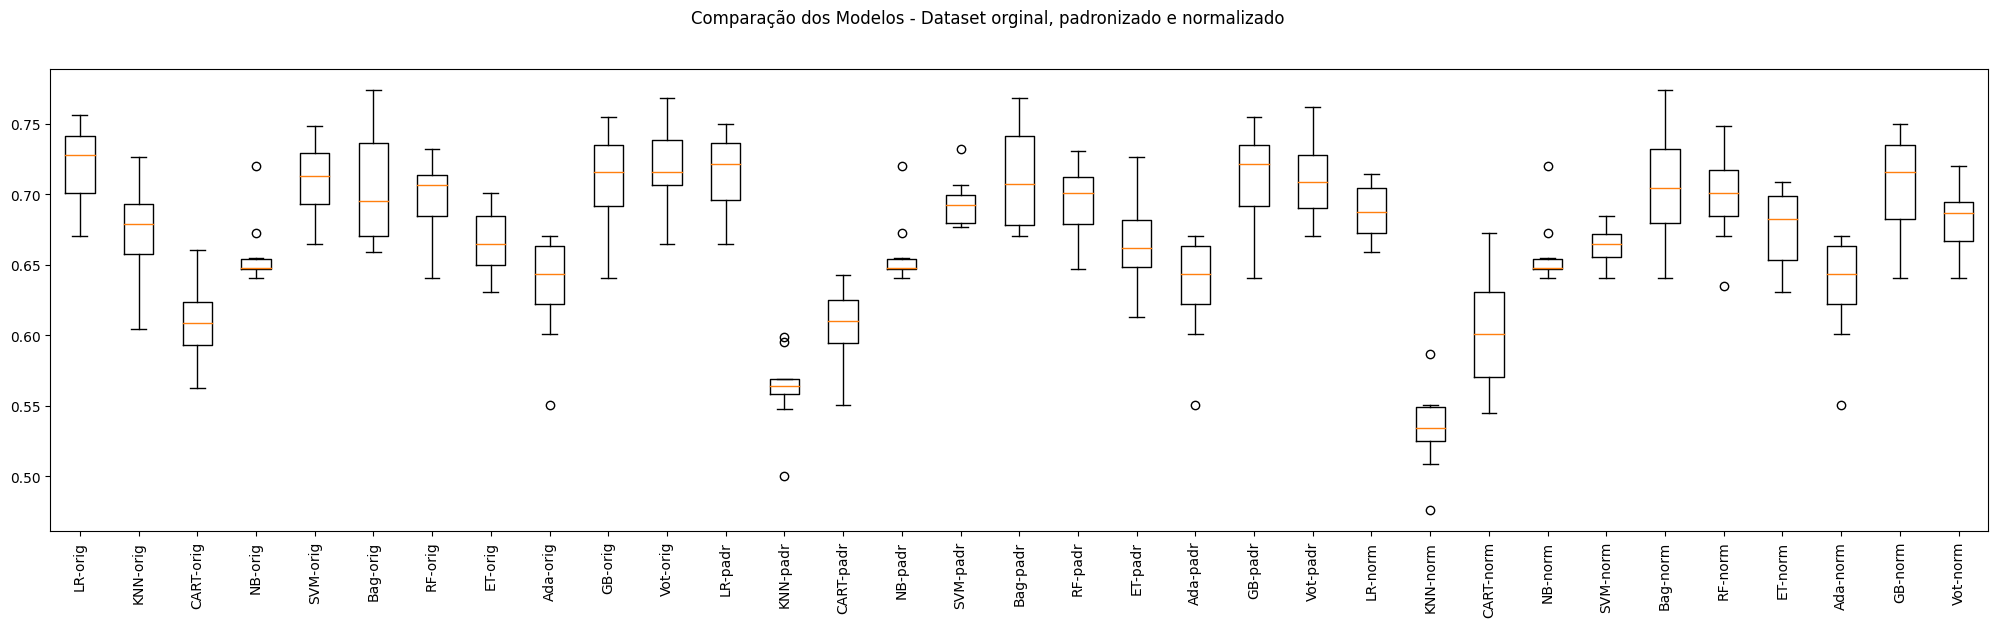

In [29]:
np.random.seed(seed) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
lr = ('LR', LogisticRegression(max_iter=lr_max_iter))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines
# A ordem de execução é da esquerda para a direita.

# Dataset original
pipelines.append(('LR-orig', Pipeline([lr])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, lr])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, lr])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, training_model in pipelines:
    cv_results = cross_val_score(training_model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # formatando para 3 casas decimais
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# Resultado da avaliação dos modelos usando normalização e padronização


```
LR-orig: 0.720 (0.026)
KNN-orig: 0.673 (0.032)
CART-orig: 0.609 (0.028)
NB-orig: 0.658 (0.022)
SVM-orig: 0.710 (0.027)
Bag-orig: 0.704 (0.037)
RF-orig: 0.696 (0.028)
ET-orig: 0.667 (0.022)
Ada-orig: 0.635 (0.035)
GB-orig: 0.710 (0.034)
Vot-orig: 0.719 (0.028)
LR-padr: 0.716 (0.025)
KNN-padr: 0.563 (0.026)
CART-padr: 0.605 (0.027)
NB-padr: 0.658 (0.022)
SVM-padr: 0.694 (0.016)
Bag-padr: 0.711 (0.034)
RF-padr: 0.696 (0.025)
ET-padr: 0.667 (0.031)
Ada-padr: 0.635 (0.035)
GB-padr: 0.711 (0.034)
Vot-padr: 0.710 (0.028)
LR-norm: 0.688 (0.018)
KNN-norm: 0.534 (0.028)
CART-norm: 0.602 (0.037)
NB-norm: 0.658 (0.022)
SVM-norm: 0.663 (0.013)
Bag-norm: 0.707 (0.037)
RF-norm: 0.698 (0.030)
ET-norm: 0.676 (0.027)
Ada-norm: 0.635 (0.035)
GB-norm: 0.708 (0.034)
Vot-norm: 0.682 (0.023)
```



# Otimização dos hiperparâmetros

A otimização de hiperparâmetros é o processo de encontrar os valores ideais para os hiperparâmetros de um modelo de machine learning. O objetivo é encontrar a combinação de hiperparâmetros que resulta no melhor desempenho do modelo.
Grid Search (força bruta)

Como Funciona o Grid Search?

1.   Definição do Espaço de Hiperparâmetros: Primeiro, define-se um conjunto de valores possíveis para cada hiperparâmetro.
2.   Avaliação das Combinações: Em seguida, cada combinação possível desses valores é avaliada.
3.   Seleção do Melhor Conjunto: A combinação de hiperparâmetros que produz o melhor desempenho é selecionada.



In [31]:
np.random.seed(seed) # definindo uma semente global para este bloco

# número máximo de iterações para o algoritmo de regressão logística
lr_max_iter = 200

# Criando os modelos e adicionando-os na lista de modelos
training_models = []
training_models.append(('LR', LogisticRegression(max_iter=lr_max_iter)))
training_models.append(('CART', DecisionTreeClassifier()))
training_models.append(('KNN', KNeighborsClassifier()))
training_models.append(('SVM', SVC()))
training_models.append(('NB', GaussianNB()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = [
    ('svm', SVC()),
    ('cart', DecisionTreeClassifier()),
    ('lr', LogisticRegression(max_iter=lr_max_iter))
]

# Criando os ensembles e adicionando-os na lista de modelos
training_models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
training_models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
training_models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
training_models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
training_models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
training_models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in training_models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear', 'polinomial']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(x_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo %s obteve a maior pontuação de %f usando os seguintes parâmetros: %s" % (name, grid.best_score_, grid.best_params_))

# Executado em 3h16 executando

Modelo LR-orig obteve a maior pontuação de 0.722149 usando os seguintes parâmetros: {'LR__C': 0.1, 'LR__solver': 'saga'}
Modelo LR-padr obteve a maior pontuação de 0.717390 usando os seguintes parâmetros: {'LR__C': 100, 'LR__solver': 'saga'}
Modelo LR-norm obteve a maior pontuação de 0.716791 usando os seguintes parâmetros: {'LR__C': 100, 'LR__solver': 'saga'}
Modelo CART-orig obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo CART-padr obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo CART-norm obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo KNN-orig obteve a maior pontuação de 0.709057 usando os seguintes parâmetros: {'KNN__metric': 'manhattan', 'KNN__n_neigh

# Resultado da otimização dos hiperparâmetros



```
Modelo LR-orig obteve a maior pontuação de 0.722149 usando os seguintes parâmetros: {'LR__C': 0.1, 'LR__solver': 'saga'}
Modelo LR-padr obteve a maior pontuação de 0.717390 usando os seguintes parâmetros: {'LR__C': 100, 'LR__solver': 'saga'}
Modelo LR-norm obteve a maior pontuação de 0.716791 usando os seguintes parâmetros: {'LR__C': 100, 'LR__solver': 'saga'}
Modelo CART-orig obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo CART-padr obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo CART-norm obteve a maior pontuação de 0.676183 usando os seguintes parâmetros: {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo KNN-orig obteve a maior pontuação de 0.709057 usando os seguintes parâmetros: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Modelo KNN-padr obteve a maior pontuação de 0.615868 usando os seguintes parâmetros: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Modelo KNN-norm obteve a maior pontuação de 0.581868 usando os seguintes parâmetros: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Modelo SVM-orig obteve a maior pontuação de 0.749679 usando os seguintes parâmetros: {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo SVM-padr obteve a maior pontuação de 0.745495 usando os seguintes parâmetros: {'SVM__C': 100, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo SVM-norm obteve a maior pontuação de 0.745498 usando os seguintes parâmetros: {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo NB-orig obteve a maior pontuação de 0.658262 usando os seguintes parâmetros: {'NB__var_smoothing': 1e-05}
Modelo NB-padr obteve a maior pontuação de 0.657667 usando os seguintes parâmetros: {'NB__var_smoothing': 1e-09}
Modelo NB-norm obteve a maior pontuação de 0.657667 usando os seguintes parâmetros: {'NB__var_smoothing': 1e-09}
Modelo Bagging-orig obteve a maior pontuação de 0.713234 usando os seguintes parâmetros: {}
Modelo Bagging-padr obteve a maior pontuação de 0.712026 usando os seguintes parâmetros: {}
Modelo Bagging-norm obteve a maior pontuação de 0.707852 usando os seguintes parâmetros: {}
Modelo RF-orig obteve a maior pontuação de 0.712065 usando os seguintes parâmetros: {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 10, 'RF__n_estimators': 100}
Modelo RF-padr obteve a maior pontuação de 0.716823 usando os seguintes parâmetros: {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 5, 'RF__n_estimators': 200}
Modelo RF-norm obteve a maior pontuação de 0.712643 usando os seguintes parâmetros: {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}
Modelo ET-orig obteve a maior pontuação de 0.693541 usando os seguintes parâmetros: {'ET__max_depth': 20, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 200}
Modelo ET-padr obteve a maior pontuação de 0.692358 usando os seguintes parâmetros: {'ET__max_depth': 10, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 2, 'ET__min_samples_split': 2, 'ET__n_estimators': 200}
Modelo ET-norm obteve a maior pontuação de 0.694119 usando os seguintes parâmetros: {'ET__max_depth': 30, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 2, 'ET__min_samples_split': 10, 'ET__n_estimators': 200}
Modelo Ada-orig obteve a maior pontuação de 0.686359 usando os seguintes parâmetros: {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
Modelo Ada-padr obteve a maior pontuação de 0.686359 usando os seguintes parâmetros: {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
Modelo Ada-norm obteve a maior pontuação de 0.686359 usando os seguintes parâmetros: {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
Modelo GB-orig obteve a maior pontuação de 0.710237 usando os seguintes parâmetros: {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 100}
Modelo GB-padr obteve a maior pontuação de 0.709043 usando os seguintes parâmetros: {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 100}
Modelo GB-norm obteve a maior pontuação de 0.711431 usando os seguintes parâmetros: {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 100}
Modelo Voting-orig obteve a maior pontuação de 0.720370 usando os seguintes parâmetros: {}
Modelo Voting-padr obteve a maior pontuação de 0.711431 usando os seguintes parâmetros: {}
Modelo Voting-norm obteve a maior pontuação de 0.679160 usando os seguintes parâmetros: {}
```




In [32]:
# Tuning do SVM

np.random.seed(seed) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'polynomial', 'rbf'],
    'SVM__gamma': [1, 0.1, 0.01, 0.001]
}

# Prepara e executa o GridSearchCV
for name, training_model in pipelines:
    grid = GridSearchCV(
        estimator=training_model, param_grid=param_grid,
        scoring=scoring, cv=kfold
    )
    grid.fit(x_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: Modelo %s obteve a melhor pontuação de %f usando os seguintes parâmetros %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: Modelo svm-orig obteve a melhor pontuação de 0.749679 usando os seguintes parâmetros {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: Modelo svm-padr obteve a melhor pontuação de 0.745495 usando os seguintes parâmetros {'SVM__C': 100, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: Modelo svm-norm obteve a melhor pontuação de 0.745498 usando os seguintes parâmetros {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}


Executado em 21 minutos

```
Sem tratamento de missings: Modelo svm-orig obteve a melhor pontuação de 0.749679 usando os seguintes parâmetros {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: Modelo svm-padr obteve a melhor pontuação de 0.745495 usando os seguintes parâmetros {'SVM__C': 100, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: Modelo svm-norm obteve a melhor pontuação de 0.745498 usando os seguintes parâmetros {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
```



# Finalização do Modelo

In [33]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
# Melhores hiperparâmetros
best_kernel = 'linear'
best_C = 0.1
best_gamma = 1
training_model = SVC(kernel=best_kernel, C=best_C)
training_model.fit(x_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = training_model.predict(x_test)
print(accuracy_score(y_test, predictions))

0.7506963788300836


In [34]:
# Preparação do modelo com TODO o dataset
training_model.fit(x, y)

SVC(C=0.1, kernel='linear')

Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [35]:
np.random.seed(seed)

pipeline = Pipeline(steps=[('SVM', training_model)])

pipeline.fit(x_train, y_train)
predictions = pipeline.predict(x_test)
print(accuracy_score(y_test, predictions))

0.7506963788300836


# Salvando os arquivos

In [36]:
# Salvando o modelo
root_folder = '/content/drive/MyDrive/Colab Notebooks/mvp-predicao-media-alunos'
model_filename = 'svm_student_performance_classifier.pkl'
with open(f'{root_folder}/models/{model_filename}', 'wb') as file:
    pickle.dump(training_model, file)

# Salvando o pipeline
pipeline_filename = 'svm_student_performance_pipeline.pkl'
with open(f'{root_folder}/pipelines/{pipeline_filename}', 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
# , columns=dataset.columns[:-1]
# , columns=[dataset.columns[-1]]
x_test_columns = dataset.columns.values[0:12]
y_test_columns = [dataset.columns.values[-1]]
x_test_df = pd.DataFrame(x_test, columns=x_test_columns)
y_test_df = pd.DataFrame(y_test, columns=y_test_columns)
x_test_df.to_csv(
    f'{root_folder}/data/x_test_dataset_student_performance.csv',
    index=False
)
y_test_df.to_csv(
    f'{root_folder}/data/y_test_dataset_student_performance.csv',
    index=False
)

# Simulando a aplicação do modelo em dados não vistos

In [37]:
# Novos dados - não sabemos a classe!
data = {
    'Age': [16, 16, 18],
    'Gender': [0, 1, 0],
    'Ethnicity': [2, 1, 3],
    'ParentalEducation': [1, 2, 3],
    'StudyTimeWeekly': [3.5282382085577235, 15.167695431798355, 9.864949860519715],
    'Absences': [16, 9, 20],
    'Tutoring': [1, 0, 0],
    'ParentalSupport': [2, 2, 2],
    'Extracurricular': [1, 0, 0],
    'Sports': [0, 0, 1],
    'Music': [1, 0, 0],
    'Volunteering': [0, 0, 0]
}

# Remover 'GradeClass'do dicionário de dados uma vez que não é um dado usada para predição
atributos = [
    'Age', 'Gender',
    'Ethnicity', 'ParentalEducation',
    'StudyTimeWeekly', 'Absences',
    'Tutoring', 'ParentalSupport',
    'Extracurricular', 'Sports',
    'Music', 'Volunteering'
]
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.to_numpy()
x_entrada = array_entrada[:,0:12]

In [38]:
# Predição de classes dos dados de entrada
notas = {
    0.0: 'A',
    1.0: 'B',
    2.0: 'C',
    3.0: 'D',
    4.0: 'E'
}
saidas = training_model.predict(x_entrada)
print([notas[saida] for saida in saidas])

['E', 'D', 'E']


# Análise de resultados

Com base no *scoring* de acurácia (accuracy), o modelo SVM se mostrou com a melhor pontuação dentre os modelos de classificação utilizados, obtendo 75% de acurácia.